<a href="https://colab.research.google.com/github/surekhag28/DeepLearning_Projects/blob/master/emotion_recognition_nlp_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.9/800.9 kB 43.7 MB/s eta 0:00:00


In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pytorch_lightning as pl
from collections import Counter
import pandas as pd
import numpy as np
import re
import nltk as nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from pytorch_lightning.callbacks import Callback

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence,pack_padded_sequence,pad_packed_sequence
from torchmetrics.classification import MulticlassF1Score, Accuracy, MulticlassConfusionMatrix
from sklearn.metrics import classification_report

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
is_cuda = torch.cuda.is_available()

if is_cuda:
  device = torch.device("cuda")
  print("GPU is available")
else:
  device = torch.device("cpu")
  print("GPU not available, use CPU instead")

GPU not available, use CPU instead


In [6]:
data_dir = "/content/drive/MyDrive/nlp/data/"

data = pd.read_csv(data_dir+"Tweet_data.csv")
data = data[["s_final_text","s_emotion"]]
data.rename(columns={"s_final_text":"tweets","s_emotion":"emotions"},inplace=True)
data.head(5)

,tweets,emotions
0,@wallacetim Honestly with the exception of air...,joy
1,“#America doesn’t challenge us we challenge th...,sadness
2,Spent #NYE2020 amongst #NSWbushfires had to ev...,joy
3,Foodbank Victoria’s first truckload of food an...,joy
4,Our first truckload of food and drinking water...,fear


In [7]:
X = data[["tweets"]]
y = data[["emotions"]]

X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [8]:
X_test.to_csv("/content/drive/MyDrive/nlp/data/tweets_test_data.csv")

In [9]:
y_train["emotions"].unique()

array(['joy', 'love', 'sadness', 'fear', 'anger', 'surprise'],
      dtype=object)

<Axes: >

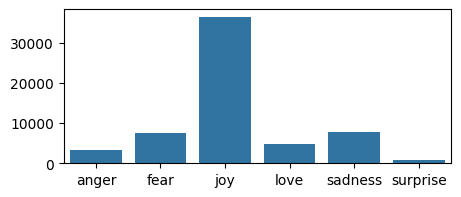

In [10]:
grouped_df = y_train.groupby("emotions")["emotions"].count()

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5,2))

sns.barplot(x=grouped_df.index.tolist(),y=grouped_df.values)
# data is imbalanced

In [11]:
def preprocess_text(orig_text):

  # Remove URLs
  text = re.sub(r'http\S+|www\S+|https\S+', '', orig_text, flags=re.MULTILINE)

  # Remove special characters except for hashtags and @mentions
  text = re.sub(r'[^a-zA-Z0-9#@ ]', '', text)

  stop_words = set(stopwords.words("english"))
  tokens = text.lower().split(" ")

  stemmer = PorterStemmer()
  tokens = [stemmer.stem(token) for token in tokens if token not in stop_words]

  if(len(tokens)>0):
    return " ".join(tokens)
  else:
    return ""

def is_empty_or_whitespace(s):
    return s.strip()

y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

X_train_proc = X_train.copy()
X_train_proc.reset_index(drop=True,inplace=True)
X_train_proc["tweets"] = X_train_proc["tweets"].apply(lambda x: preprocess_text(x))
X_train_proc["tweets"] = X_train_proc["tweets"].apply(lambda x:is_empty_or_whitespace(x))

X_test_proc = X_test.copy()
X_test_proc.reset_index(drop=True,inplace=True)
X_test_proc["tweets"] = X_test_proc["tweets"].apply(lambda x: preprocess_text(x))
X_test_proc["tweets"] = X_test_proc["tweets"].apply(lambda x:is_empty_or_whitespace(x))

In [12]:
# few of the records comes empty after doing preprocessing, now we need to remove them
def remove_empty_records(df_input, df_target):
  indices = df_input[df_input["tweets"]==""].index.tolist()
  print(indices)
  df_target.drop(indices, inplace=True)
  df_input.drop(indices, inplace=True)
  df_target = df_target.reset_index(drop=True)
  df_input = df_input.reset_index(drop=True)

  return df_input, df_target

X_train_proc,y_train = remove_empty_records(X_train_proc,y_train)
X_test_proc,y_test = remove_empty_records(X_test_proc,y_test)

[1255, 1505, 2783, 3290, 4341, 4432, 5678, 7452, 7829, 7934, 9767, 10437, 10438, 11069, 11397, 12011, 12495, 12954, 13188, 13232, 14713, 15420, 15534, 15663, 16622, 17072, 17134, 17305, 18599, 18921, 19176, 19567, 20615, 20813, 21577, 21832, 26068, 28236, 28378, 29067, 29597, 30242, 31435, 31973, 32489, 34976, 35554, 35774, 36331, 38825, 39030, 40409, 42076, 42527, 42534, 43379, 44300, 44381, 44435, 44795, 45161, 45223, 45876, 47142, 47718, 47761, 48311, 49668, 50385, 50814, 51255, 51483, 51769, 51842, 52594, 52691, 55204, 55218, 55457, 55564, 55794, 56894, 57144, 57294, 58185, 58236, 58582, 59267, 59324, 60174, 60446]
[17, 210, 396, 2157, 2256, 4093, 5659, 6415, 6464, 6511, 6847, 6892, 7889, 8729, 8940, 9104, 9678, 11131, 11680, 12623, 13114, 14458, 14771]


In [13]:
X_train_proc[X_train_proc["tweets"]==""]
#X_train_proc.to_csv("/content/drive/MyDrive/nlp/data/train_data.csv")

,tweets


In [14]:
X_train_proc.loc[2781,"tweets"]

'honour ask volunt act head chef coupl day bairnsdal bushir relief centr work amaz local volunt car pack food apron amp knive amp im hit road stand one alway unit one commun'

In [15]:
X_train_proc["tweets"].isna().sum()

0

In [16]:
X_train_proc[X_train_proc["tweets"]==False]

,tweets


In [17]:
X_test_proc.head(2)

,tweets
0,today launch citi sydney @ozharvest food relie...
1,pleas rt #mallacoota wildlif need help today h...


In [18]:
len(X_test_proc)

15181

In [19]:
# building vocab using train data

counter = Counter()
tweets = X_train_proc["tweets"]

for tweet in tweets:
  counter.update(tweet.split())

word_to_index = {word:index for index,(word,freq) in enumerate(counter.items())}
oov_token = "<OOV>"
word_to_index[oov_token] = 0

In [20]:
from sklearn.preprocessing import LabelEncoder

def text_to_numerical(texts):

  texts = [[word_to_index[word] if word in word_to_index else word_to_index[oov_token] for word in text.split()] for text in texts]
  return texts

label_encoder = LabelEncoder()
labels = list(label_encoder.fit_transform(y_train["emotions"]))
texts = X_train_proc["tweets"]
numerical_texts = text_to_numerical(texts)

train_texts,val_texts,train_labels,val_labels = train_test_split(numerical_texts,labels,test_size=0.2,random_state=12)

test_texts = text_to_numerical(X_test_proc["tweets"])
test_labels = list(label_encoder.transform(y_test["emotions"]))

In [22]:
# defining dataset

class EmotionDataset(Dataset):
  def __init__(self,texts,labels):
    self.texts = texts
    self.labels = labels

  def __len__(self):
    return len(self.texts)

  def __getitem__(self,idx):
    return torch.tensor(self.texts[idx]), torch.tensor(self.labels[idx])

def collate_fn(batch):
  texts,labels = zip(*batch)
  lengths = [len(seq) for seq in texts]
  padded_texts = pad_sequence(texts, batch_first=True, padding_value=0)
  return padded_texts, torch.tensor(labels), lengths

train_dataset = EmotionDataset(train_texts,train_labels)
val_dataset = EmotionDataset(val_texts,val_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [23]:
# defining model architecture

class EmotionModel(pl.LightningModule):
  def __init__(self,vocab_size,embed_dim,hidden_dim,output_dim,n_layers,bidirectional,dropout):
    super(EmotionModel, self).__init__()

    self.embedding = nn.Embedding(vocab_size, embed_dim)
    self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
    self.fc = nn.Linear(hidden_dim*2 if bidirectional else hidden_dim, output_dim)
    self.dropout = nn.Dropout(dropout)

    self.criterion = nn.CrossEntropyLoss()
    self.epoch_train_loss = []
    self.epoch_val_loss = []
    self.epoch_val_acc = []
    self.epoch_val_f1 = []

    self.accuracy = Accuracy(task="multiclass",num_classes=output_dim)
    self.f1_score = MulticlassF1Score(num_classes=output_dim, average='macro')
    self.confusion_matrix = MulticlassConfusionMatrix(num_classes=output_dim)

  def forward(self, texts, text_lengths):
    embedded = self.embedding(texts)

    packed_embedded = pack_padded_sequence(embedded, text_lengths, batch_first=True, enforce_sorted=False)
    output, (hidden,cell) = self.lstm(packed_embedded)
    hidden = self.dropout(torch.cat((hidden[-2,:,:],hidden[-1,:,:]))if self.lstm.bidirectional else hidden[-1,:,:])
    out = self.fc(hidden)

    return out

  def training_step(self, batch, batch_idx):
    x,y,lengths = batch
    #print(lengths)
    logits = self(x,lengths)
    loss = self.criterion(logits,y)
    self.log("train_loss",loss,prog_bar=True)
    return loss

  def validation_step(self, batch, batch_idx):
    x,y,lengths = batch

    logits = self(x,lengths)
    loss = self.criterion(logits,y)

    y_pred = torch.argmax(logits,dim=1)
    val_acc = self.accuracy(y_pred,y)
    val_f1_score = self.f1_score(y_pred,y)

    self.log("val_loss",loss,prog_bar=True)
    self.log("val_acc",val_acc,prog_bar=True)
    self.log("val_f1_score",val_f1_score,prog_bar=True)
    return loss

  def test_step(self, batch, batch_idx):

    x,y,lengths = batch
    logits = self(x,lengths)
    loss = self.criterion(logits,y)

    y_pred = torch.argmax(logits,dim=1)
    test_acc = self.accuracy(y_pred,y)
    self.log("test_acc",test_acc,on_step=False,on_epoch=True,prog_bar=True)

    test_f1_score = self.f1_score(y_pred,y)
    self.log("test_f1_score",test_f1_score,on_step=False,on_epoch=True,prog_bar=True)

    self.confusion_matrix.update(y_pred, y)


    return loss

  def on_train_epoch_end(self):
    avg_train_loss = self.trainer.callback_metrics["train_loss"].mean()
    self.epoch_train_loss.append(avg_train_loss.item())

  def on_validation_epoch_end(self):
    avg_val_loss = self.trainer.callback_metrics["val_loss"].mean()
    avg_val_acc = self.trainer.callback_metrics["val_acc"].mean()
    avg_val_f1 = self.trainer.callback_metrics["val_f1_score"].mean()
    self.epoch_val_loss.append(avg_val_loss)
    self.epoch_val_acc.append(avg_val_acc)
    self.epoch_val_f1.append(avg_val_f1)


  def plot_losses(self):
    epochs = list(range(0, self.current_epoch))
    print(epochs,self.epoch_train_loss,self.epoch_val_loss)
    print(len(epochs),len(self.epoch_train_loss),len(self.epoch_val_loss))
    plt.plot(epochs, self.epoch_train_loss, label='Train Loss')
    plt.plot(epochs, self.epoch_val_loss[1:], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train vs Validation Loss')
    plt.show()

  def plot_confusion_matrix(self,class_names):
    self.confusion_matrix.plot(labels=class_names)


  def configure_optimizers(self):
    optimizer = optim.Adam(self.parameters())
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
    return [optimizer], [scheduler]

In [24]:
# Model initialization
VOCAB_SIZE = len(word_to_index)+1
EMBED_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 6
N_LAYERS = 2
BIDIRECTIONAL = False
DROPOUT = 0.5

class_names = label_encoder.inverse_transform([0,1,2,3,4,5]).tolist()
model = EmotionModel(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT)

epochs = 5
# Lightning Trainer
trainer = pl.Trainer(max_epochs=epochs)
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type                      | Params
---------------------------------------------------------------
0 | embedding        | Embedding                 | 6.5 M 
1 | lstm             | LSTM                      | 892 K 
2 | fc               | Linear                    | 1.5 K 
3 | dropout          | Dropout                   | 0     
4 | criterion        | CrossEntropyLoss          | 0     
5 | accuracy         | MulticlassAccuracy        | 0     
6 | f1_score         | MulticlassF1Score         | 0     
7 | confusion_matrix | MulticlassConfusionMatrix | 0     
-----------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 17. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


[0, 1, 2, 3, 4] [0.49675676226615906, 1.101352572441101, 0.11078693717718124, 0.8562995791435242, 0.10461800545454025] [tensor(1.7697), tensor(0.5469), tensor(0.3424), tensor(0.3139), tensor(0.3285), tensor(0.3444)]
5 5 6


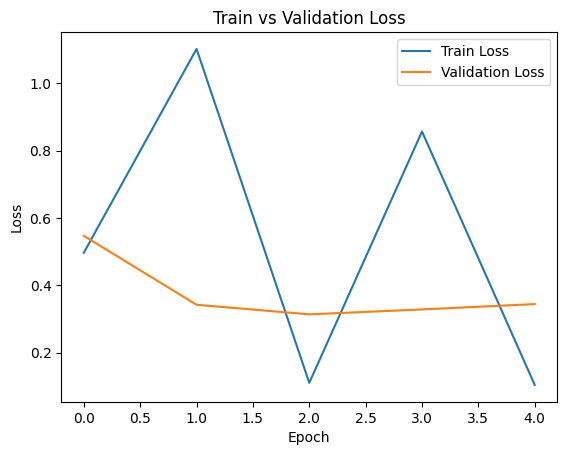

In [25]:
model.plot_losses()

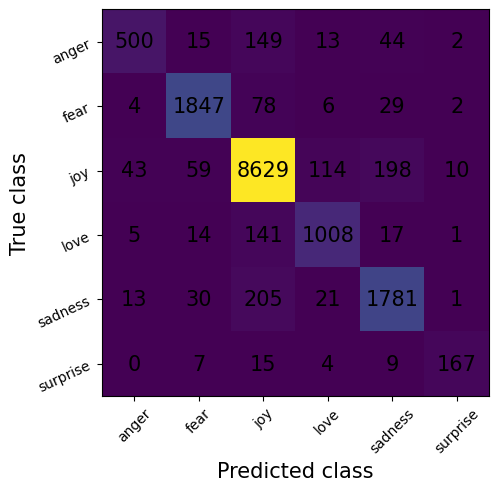

In [30]:
#model.confusion_matrix.plot()
model.plot_confusion_matrix(class_names)

In [27]:
# testing on test dataset

test_dataset = EmotionDataset(test_texts,test_labels)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=False,collate_fn=collate_fn)

In [28]:
test_results = trainer.test(model, test_loader)
print(test_results)
test_accuracy = test_results[0]['test_acc']
f1_score = test_results[0]['test_f1_score']
print("Test Accuracy:", test_accuracy)
print("Test F1-score:", f1_score)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 13. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9177260994911194     │
│       test_f1_score       │    0.8501972556114197     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.9177260994911194, 'test_f1_score': 0.8501972556114197}]
Test Accuracy: 0.9177260994911194
Test F1-score: 0.8501972556114197


In [29]:
# prediction on unknown dataset
tweet = ["@ebuckleylennox That‚Äôs because the basics card funnels money into certain shops \
        generally with astronomical prices. Increasing food insecurity and long term stress \
        of entire extended families mainly women. \
        The #Indue card is an abominable abuse of human rights."]

proc_tweet = [preprocess_text(tweet[0])]
#print(proc_tweet)


embedded_text = text_to_numerical(proc_tweet)
lengths = [len(embedded_text[0])]
#print(embedded_text,lengths)

logits = model(torch.tensor(embedded_text),lengths)
#print(logits)

predictions = torch.argmax(logits,dim=1)
print(predictions)

predicted_labels = label_encoder.inverse_transform(predictions.numpy())
#label = "Positive" if int(predicted_label)==1 else "Negative"
print("The catgeory is :- ",predicted_labels)

tensor([4])
The catgeory is :-  ['sadness']
